In [2]:
import sys

sys.path.append("..")

import os
import subprocess
from collections.abc import Iterable
from glob import glob
from os.path import dirname, join
from statistics import mode

import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch.optim
from IPython.display import HTML, display
from joblib import Parallel, delayed
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FuncFormatter
from millify import millify
from PIL import Image
from pyproj import Transformer
from skimage.color import label2rgb
from skimage.measure import find_contours, label
from tqdm import tqdm

from pred2raster import pred2raster
from sample_selection import get_components_stats
from src.io_operations import (fix_relative_paths, get_image_metadata,
                               get_image_pixel_scale, load_args, read_tiff,
                               read_yaml)
from utils import *

import warnings
warnings.filterwarnings('ignore')
import textwrap
from seaborn import color_palette
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm


In [3]:
DEFAULT_TITLE_SIZE = 10
DEFAULT_FONT_SIZE = 7

# Style plots
sns.set_theme(style="whitegrid")

# set figsize
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["figure.dpi"] = 200

plt.rc('xtick', labelsize=DEFAULT_FONT_SIZE)  
plt.rc('ytick', labelsize=DEFAULT_FONT_SIZE)

# Dict to store colors
dict_colors = {}

# Parallel jobs to load m etrics
N_JOBS = 25

In [4]:
# Repo with training data
INPUT_PATH = "../amazon_input_data"

# repo with model outputs
VERSION_FOLDER = "13_amazon_data"
DATA_PATH = join(dirname(os.getcwd()), VERSION_FOLDER)

# load args from the version
args = load_args(join(DATA_PATH, "args.yaml"))

In [5]:
id_tree = pd.read_csv(join(INPUT_PATH,"id_trees.csv"), index_col="label_num")["tree_name"].sort_values()

In [6]:
TRAIN_GT = read_tiff(args.train_segmentation_path)
COMP_TRAIN_GT = label(TRAIN_GT)

TEST_GT = read_tiff(args.test_segmentation_path)

# Remove Data from TRAIN in TEST
TEST_GT = np.where(TRAIN_GT > 0, 0, TEST_GT)

COMP_TEST_GT = label(TEST_GT)

In [7]:
stats_test_gt = get_components_stats(COMP_TEST_GT, TEST_GT)
df_count_tree_gt = stats_test_gt.groupby("tree_type", as_index=False).size()
df_count_tree_gt["tree_name"] = df_count_tree_gt["tree_type"].map(id_tree)


In [8]:

def wrap_text(text, width, break_long_words=False):
    return textwrap.fill(text, width=width, break_long_words=break_long_words)

def format_y_ticks(value, _):
    return millify(value, precision=1)


def normalize_img(image):
    
    image = (image - image.min(axis=(0,1))) / (np.quantile(image, 0.99, axis=(0,1)) - image.min())
    
    return image

In [9]:
def get_iter_folders(output_folder):
    # load data from all iterations
    iter_folders = os.listdir(output_folder)

    iter_folders = [join(output_folder, folder) for folder in iter_folders if folder.startswith("iter_")]

    iter_folders.sort()
    iter_folders = iter_folders[1:-1].copy()
    
    return iter_folders.copy()

iter_folders = get_iter_folders(DATA_PATH)

In [11]:


def get_component_metrics(iter_folder):
    
    all_labels = read_tiff(join(iter_folder, "new_labels", "all_labels_set.tif"))

    test_id_in_pred = np.unique(COMP_TEST_GT[all_labels>0])
    test_id_in_pred = test_id_in_pred[np.nonzero(test_id_in_pred)].copy()

    metrics_by_components = list()

    for id_test in tqdm(test_id_in_pred, leave=False, position=1):
        test_id_filter = (COMP_TEST_GT == id_test)
        pred_comp = all_labels[test_id_filter].copy()
        
        label_test = TEST_GT[test_id_filter].max()
        
        if np.max(pred_comp) == 0:
            metrics_by_components.append(
                {"id_test":label_test, "id_pred": None, "id_preds": [None], "count": None, "intersection_rate":None, "id_comp_test": id_test}
            )
        
        
        labels_pred, count = np.unique(pred_comp[pred_comp>0], return_counts=True)
        
        if labels_pred.shape[0] > 1:
            label_pred = labels_pred[np.argmax(count)]
        
        else:
            label_pred = labels_pred[0]
        
        intersection_rate = np.mean(pred_comp == label_pred)

        metrics_by_components.append(
            {"id_test": label_test, "id_pred": label_pred, "id_preds": labels_pred, "count": count, "intersection_rate":intersection_rate, "id_comp_test": id_test}
        )
    
    metrics_by_components = pd.DataFrame(metrics_by_components)
    metrics_by_components["iter_folder"] = iter_folder
    
    return metrics_by_components

path_metrics_by_iter_comp = join(DATA_PATH, "df_metrics_by_iter_comp.parquet")
if os.path.exists(path_metrics_by_iter_comp):
    df_metrics_by_iter_comp = pd.read_parquet(path_metrics_by_iter_comp)
    
else:
    metrics_by_iter_comp = Parallel(n_jobs=N_JOBS)(delayed(get_component_metrics)(iter_folder) for iter_folder in tqdm(iter_folders, position=0))
    df_metrics_by_iter_comp = pd.concat(metrics_by_iter_comp)
    df_metrics_by_iter_comp["iter_num"] = df_metrics_by_iter_comp["iter_folder"].apply(lambda x: int(x.split("_")[-1]))

    df_metrics_by_iter_comp["tree_pred"] = df_metrics_by_iter_comp["id_pred"].map(id_tree)
    df_metrics_by_iter_comp["tree_test"] = df_metrics_by_iter_comp["id_test"].map(id_tree)
    df_metrics_by_iter_comp["correct"] = df_metrics_by_iter_comp["id_pred"] == df_metrics_by_iter_comp["id_test"]

    df_metrics_by_iter_comp.to_parquet(join(DATA_PATH, "df_metrics_by_iter_comp.parquet"))

In [12]:

df_metrics_by_iter_comp = df_metrics_by_iter_comp[df_metrics_by_iter_comp["intersection_rate"] > 0.05].copy()

In [14]:
f1_comp_by_iter_by_tree = []

for iter_num in df_metrics_by_iter_comp["iter_num"].unique():
    
    iter_filter = df_metrics_by_iter_comp["iter_num"] == iter_num
    
    f1_iter = metrics.f1_score(
        y_true = df_metrics_by_iter_comp[iter_filter]["id_test"],
        y_pred = df_metrics_by_iter_comp[iter_filter]["id_pred"],
        average = None,
        labels = list(range(1,18))
    )
    
    f1_comp_by_iter_by_tree.append({"iter_num": iter_num, "f1_score": f1_iter})

df_f1_comp_by_iter_by_tree = pd.DataFrame(f1_comp_by_iter_by_tree).set_index("iter_num")

df_f1_comp_by_iter_by_tree = df_f1_comp_by_iter_by_tree["f1_score"].apply(pd.Series).copy()

df_f1_comp_by_iter_by_tree.columns = df_f1_comp_by_iter_by_tree.columns+1

df_f1_comp_by_iter_by_tree.columns = df_f1_comp_by_iter_by_tree.columns.map(id_tree)

df_f1_comp_by_iter_by_tree = df_f1_comp_by_iter_by_tree.stack().reset_index()
df_f1_comp_by_iter_by_tree.rename(columns={"level_1": "tree_name", 0: "f1_score"}, inplace=True)

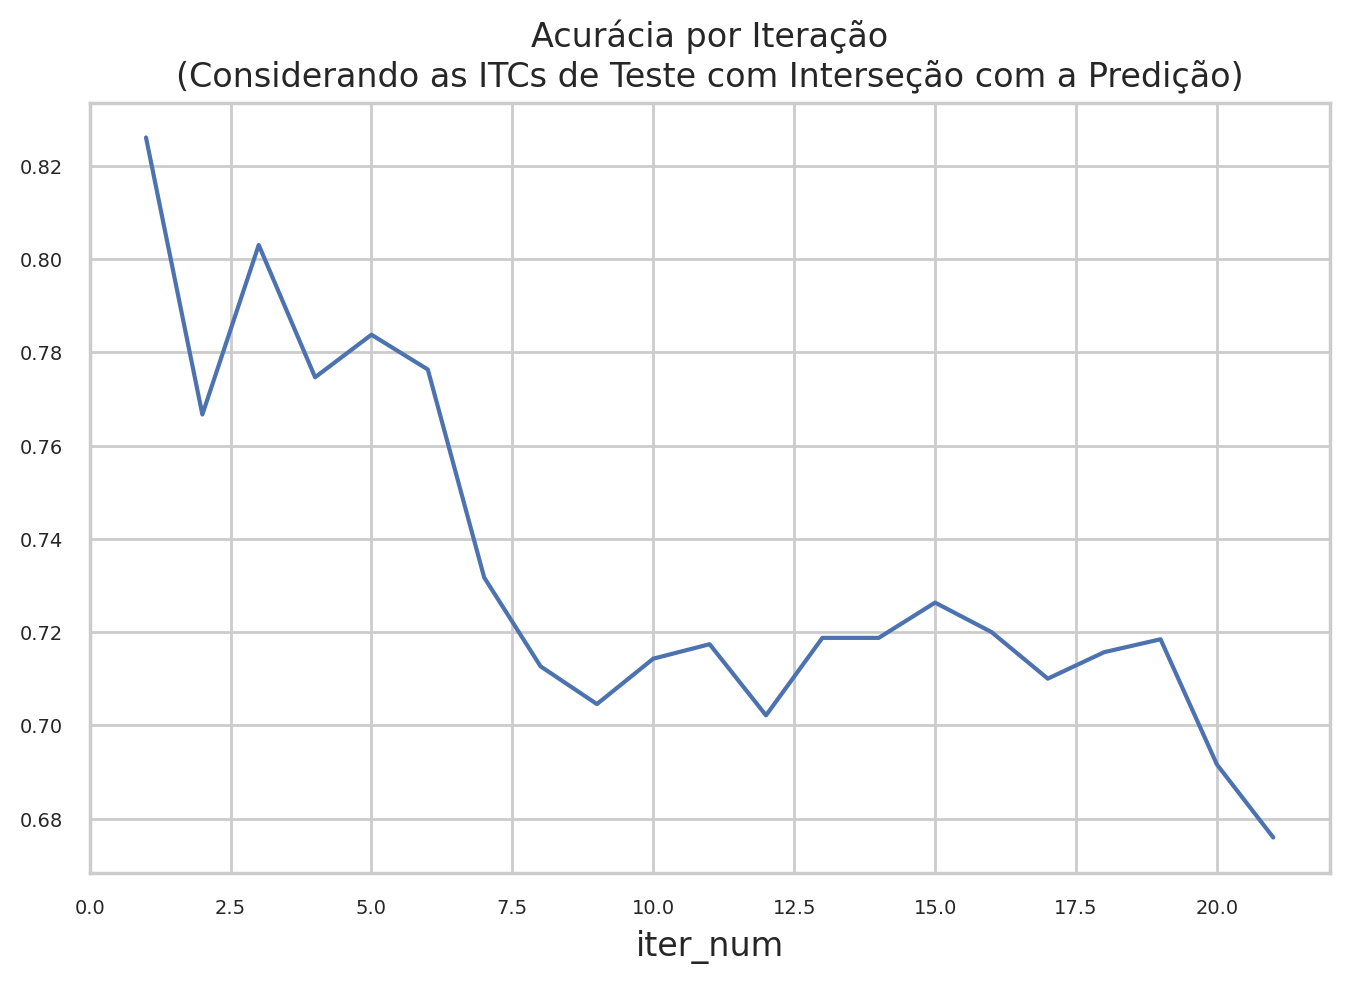

In [209]:
plt.title("Acurácia por Iteração\n(Considerando as ITCs de Teste com Interseção com a Predição)")

df_metrics_by_iter_comp.groupby("iter_num")["correct"].mean().plot()

plt.show()

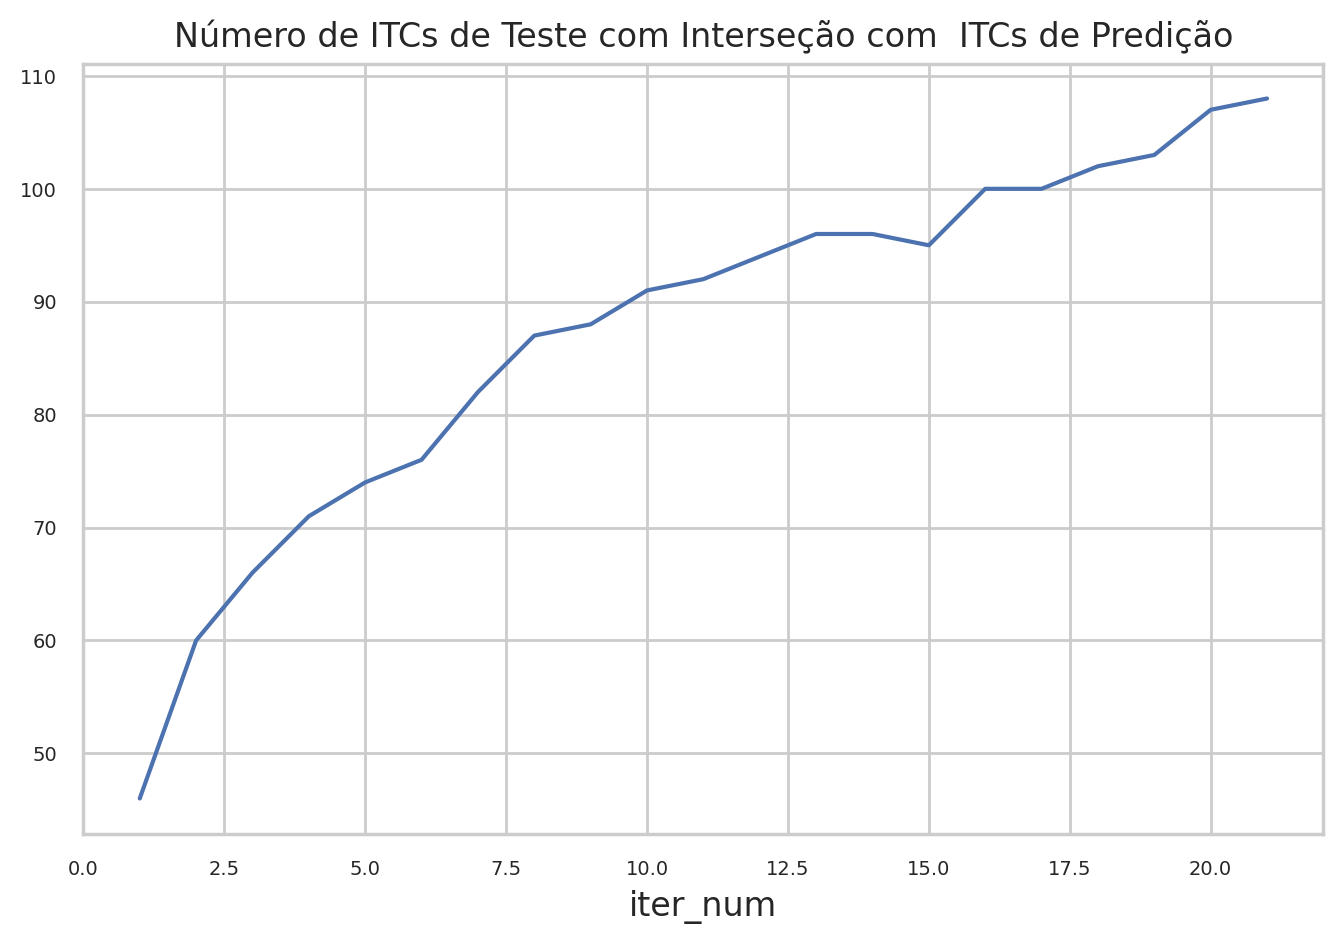

In [211]:
plt.title("Número de ITCs de Teste com Interseção com  ITCs de Predição")
df_metrics_by_iter_comp.groupby("iter_num").size().plot()
plt.show()

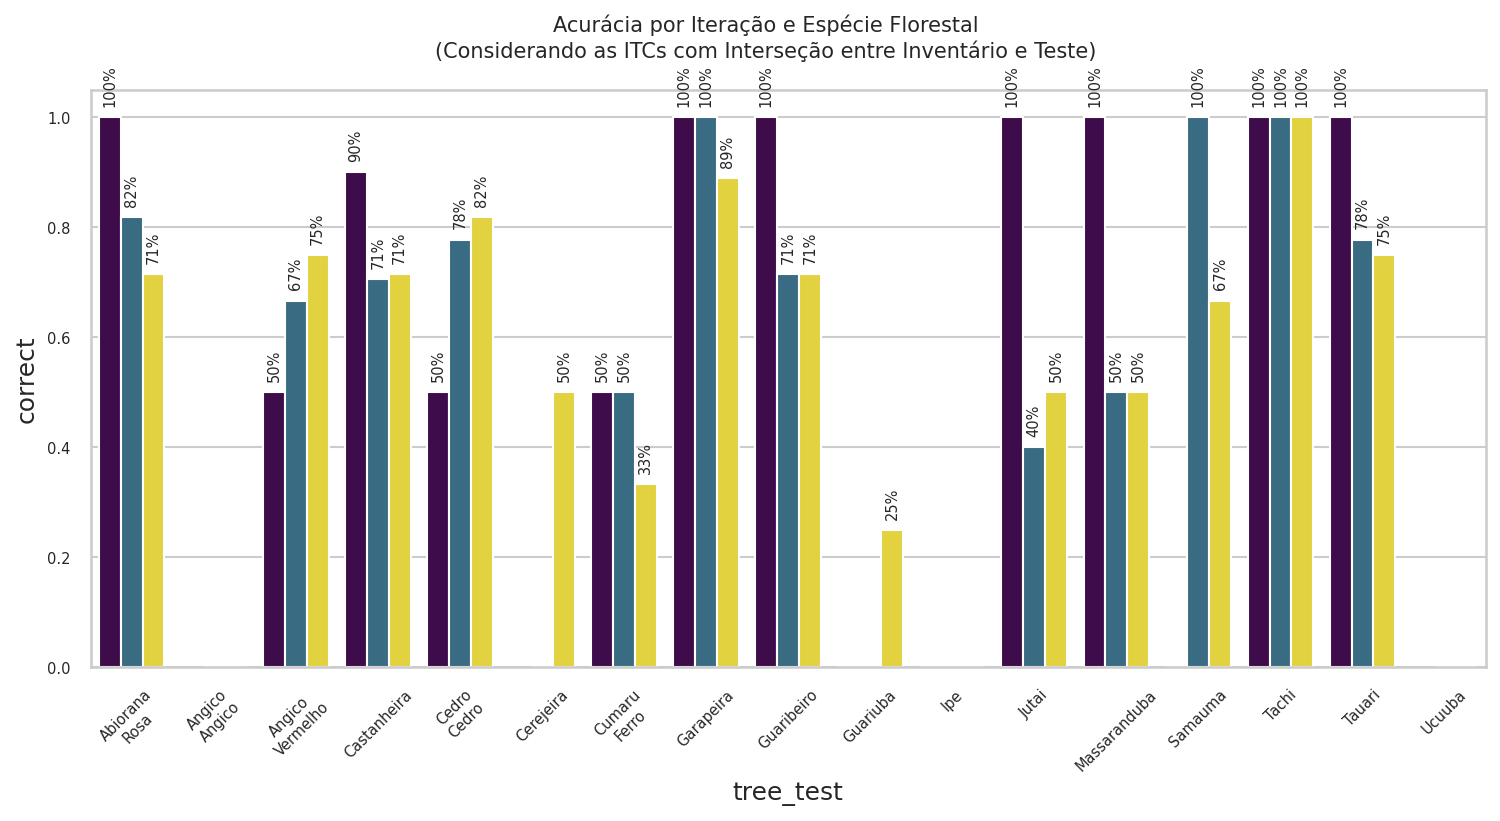

In [212]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

fig.suptitle("Acurácia por Iteração e Espécie Florestal\n(Considerando as ITCs com Interseção entre Inventário e Teste)", fontsize=DEFAULT_TITLE_SIZE)

accuracy_by_iter_tree = df_metrics_by_iter_comp.groupby(["iter_num", "tree_test"], as_index=False)["correct"].mean()
iters_chosen = [1,8,20 ]
# groupped bar
sns.barplot(
    data=accuracy_by_iter_tree[accuracy_by_iter_tree["iter_num"].isin(iters_chosen)],
    x="tree_test",
    y="correct",
    hue="iter_num",
    palette="viridis",
    dodge=True,
    order=df_metrics_by_iter_comp["tree_test"].sort_values().unique(),
)

# remove legend
ax.get_legend().remove()
ax.tick_params(axis='x', rotation=45)
ax.set_xticklabels([wrap_text(label.get_text(), 9, False) for label in ax.get_xticklabels()])

# add labels to the bars
for p in ax.patches:
    if p.get_height() > 0:
        
        ax.annotate(
            f"{p.get_height():.0%}",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="bottom",
            xytext=(0, 5),
            textcoords="offset points",
            fontsize=DEFAULT_FONT_SIZE,
            rotation=90,
        )

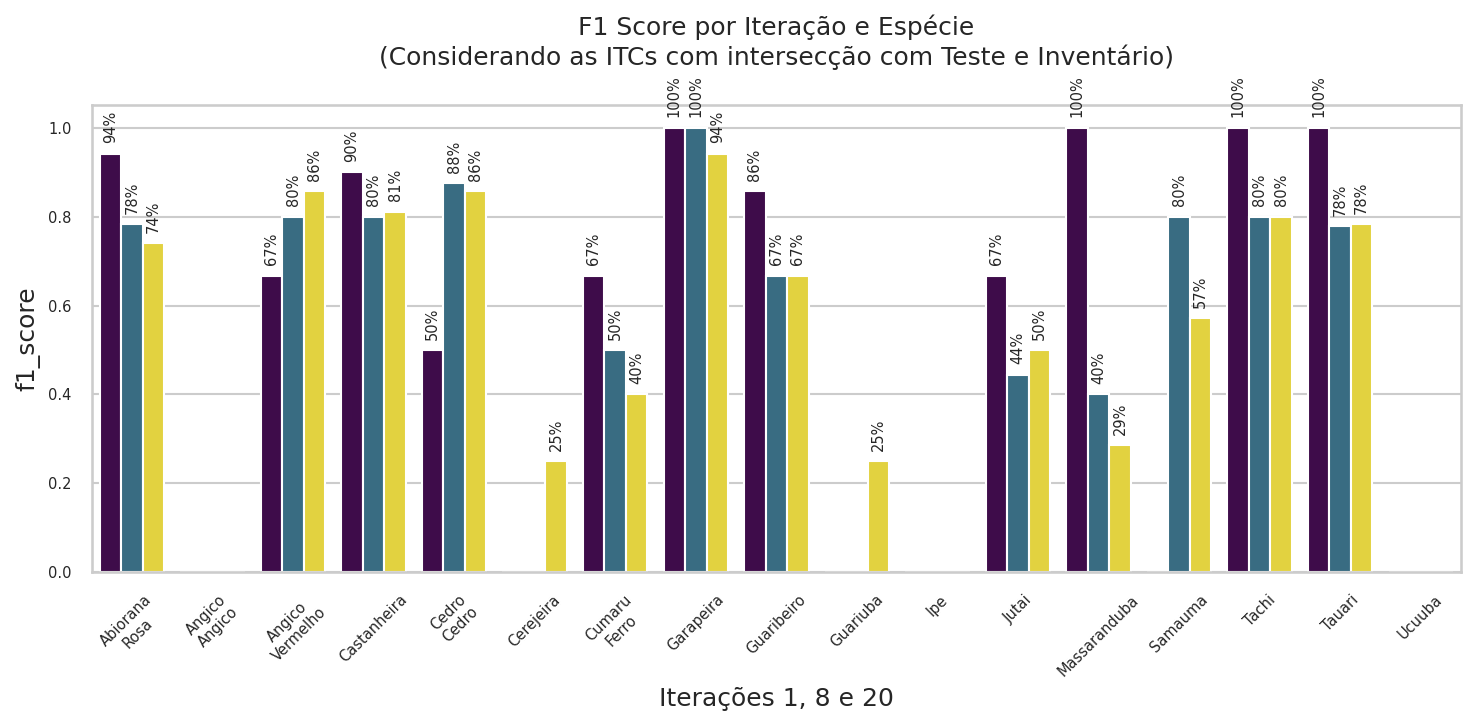

In [222]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
iters_chosen = [1,8,20 ]
plt.title("F1 Score por Iteração e Espécie\n(Considerando as ITCs com intersecção com Teste e Inventário)\n")
# groupped bar
sns.barplot(
    data=df_f1_comp_by_iter_by_tree[df_f1_comp_by_iter_by_tree["iter_num"].isin(iters_chosen)],
    x="tree_name",
    y="f1_score",
    hue="iter_num",
    palette="viridis",
    dodge=True,
    order=df_f1_comp_by_iter_by_tree["tree_name"].sort_values().unique(), 
    ax=ax
)

# remove legend
ax.get_legend().remove()
ax.tick_params(axis='x', rotation=45)
ax.set_xticklabels([wrap_text(label.get_text(), 9, False) for label in ax.get_xticklabels()])

# add labels to the bars
for p in ax.patches:
    if p.get_height() > 0:
        
        ax.annotate(
            f"{p.get_height():.0%}",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="bottom",
            xytext=(0, 5),
            textcoords="offset points",
            fontsize=DEFAULT_FONT_SIZE,
            rotation=90,
        )
ax.set_xlabel("Iterações 1, 8 e 20")

plt.tight_layout()
plt.show()

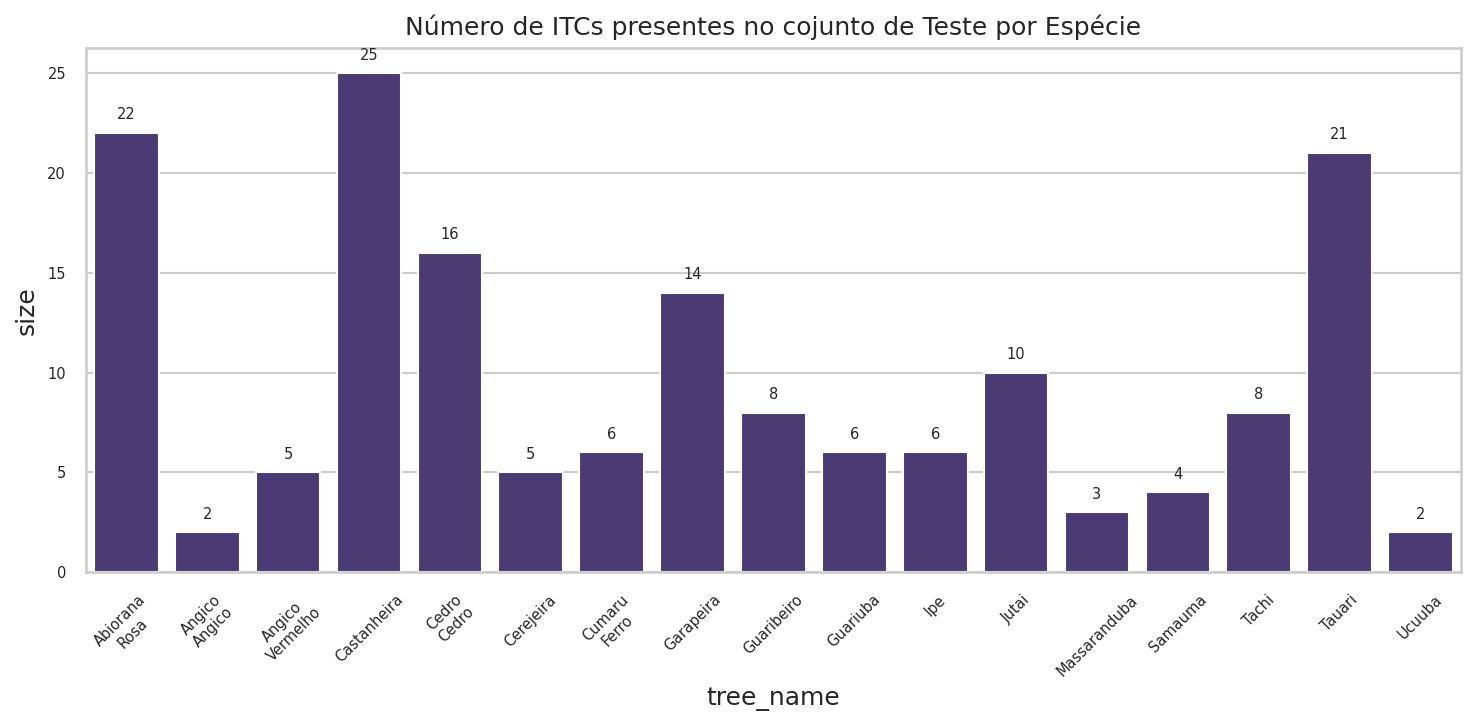

In [219]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
ax.set_title("Número de ITCs presentes no cojunto de Teste por Espécie")
iters_chosen = [1,8,20 ]

# groupped bar
sns.barplot(
    data=df_count_tree_gt,
    x="tree_name",
    y="size",
    # palette=sns.color_palette("viridis")[0],
    color=sns.color_palette("viridis")[0],
    order=df_f1_comp_by_iter_by_tree["tree_name"].sort_values().unique(),
    ax=ax
)

# remove legend
ax.tick_params(axis='x', rotation=45)
ax.set_xticklabels([wrap_text(label.get_text(), 9, False) for label in ax.get_xticklabels()])

# add labels to the bars
for p in ax.patches:
    if p.get_height() > 0:
        
        ax.annotate(
            f"{p.get_height():.0f}",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="bottom",
            xytext=(0, 5),
            textcoords="offset points",
            fontsize=DEFAULT_FONT_SIZE,
        )
    
plt.tight_layout()
plt.show()

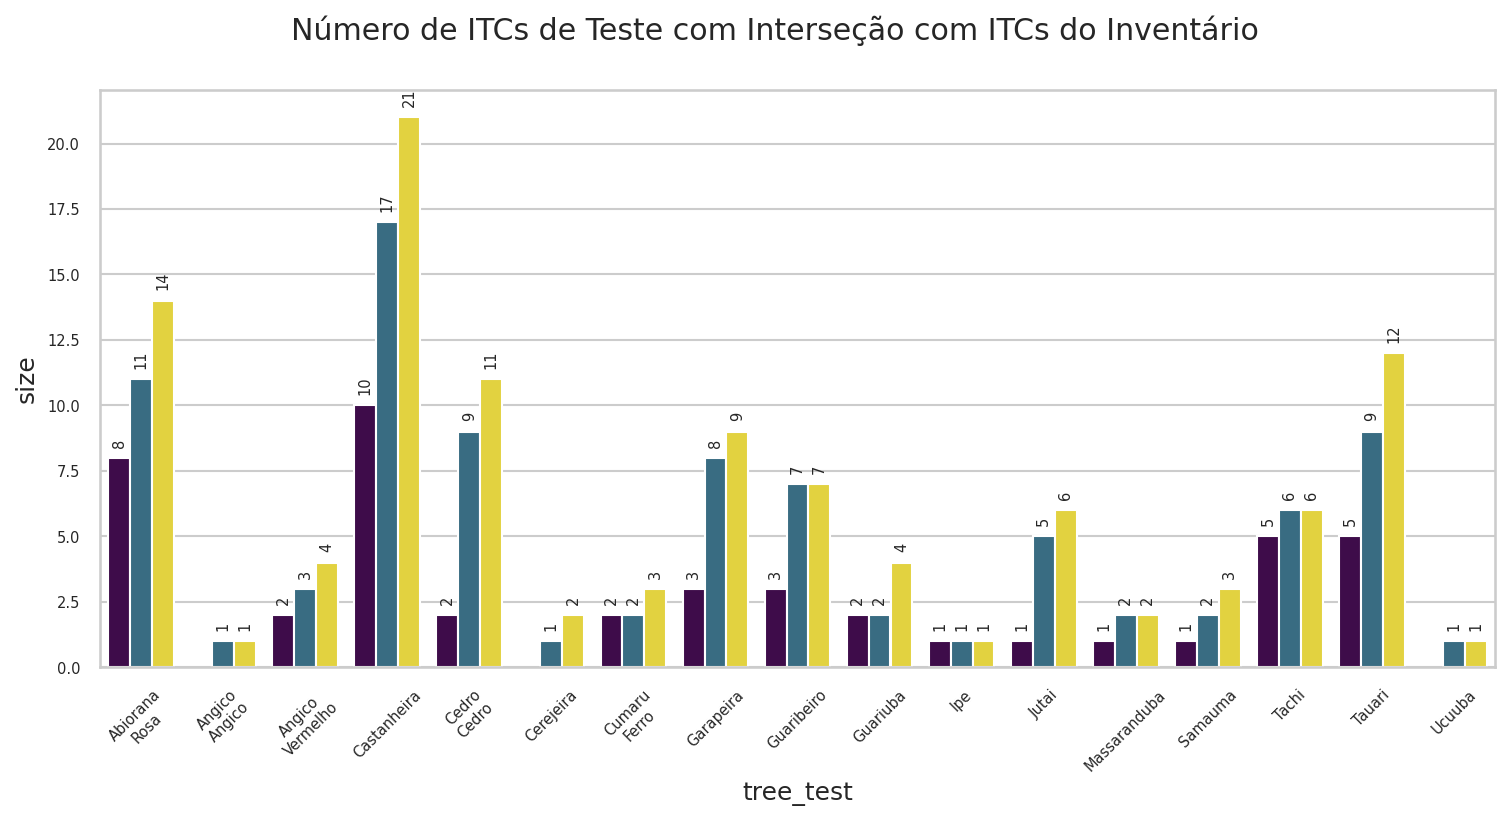

In [228]:
df_count_tree = df_metrics_by_iter_comp[df_metrics_by_iter_comp.iter_num.isin(iters_chosen)].groupby(["iter_num", "tree_test"], as_index=False).size()

fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

fig.suptitle("Número de ITCs de Teste com Interseção com ITCs do Inventário")

iters_chosen = [1,8,20 ]
# groupped bar
sns.barplot(
    data=df_count_tree,
    x="tree_test",
    y="size",
    hue="iter_num",
    palette="viridis",
    dodge=True,
    order=df_count_tree["tree_test"].sort_values().unique()
)

# remove legend
ax.get_legend().remove()
ax.tick_params(axis='x', rotation=45)
ax.set_xticklabels([wrap_text(label.get_text(), 9, False) for label in ax.get_xticklabels()])

# add labels to the bars
for p in ax.patches:
    if p.get_height() > 0:
        
        ax.annotate(
            f"{p.get_height():.0f}",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="bottom",
            xytext=(0, 5),
            textcoords="offset points",
            fontsize=DEFAULT_FONT_SIZE,
            rotation=90,
        )

# Quantidade de ITCS e F1-Score

In [18]:
def get_iter_stats(iter_folder, labels_file="all_labels_set.tif"):
    
    if "all_labels" in labels_file:
        ITER_STATS_PATH = join(DATA_PATH, iter_folder, "all_labels_stats.parquet")
        
    if "selected_labels" in labels_file:
        ITER_STATS_PATH = join(DATA_PATH, iter_folder, "selected_labels_stats.parquet")
    
    if os.path.exists(ITER_STATS_PATH):
        return pd.read_parquet(ITER_STATS_PATH)
    
    num_iter = int(iter_folder.split("_")[1])
    
    if num_iter != 0:
        label_path = join(DATA_PATH, iter_folder, "new_labels", labels_file)
        
    else:
        label_path = args.train_segmentation_path

    label_img = read_tiff(label_path)

    components = label(label_image = label_img)

    components_stats = get_components_stats(components, label_img)
    components_stats.reset_index(inplace=True)


    components_stats["iter"] = f"iter_{num_iter:03d}"

    components_stats["iter_num"] = num_iter
    
    # save parquet with stats at
    components_stats.to_parquet(ITER_STATS_PATH)
    
    return components_stats

In [19]:
OUTPUT_PATH_ALL_LABELS_STATS = join(DATA_PATH, "all_labels_stats.parquet")

# carregando dados sobre cada iteracao
all_iter_stats = Parallel(n_jobs=N_JOBS)(
    delayed(get_iter_stats)(iter_folder, "all_labels_set.tif")
    for iter_folder in iter_folders
)

# all_iter_stats corresponde dados gerados para o banco de imagens
all_labels_stats = pd.concat(all_iter_stats)

all_labels_stats["tree_name"] = all_labels_stats["tree_type"].map(id_tree);


In [48]:
dict_colors["tree_name"] = {
    key: color for key, color in zip(id_tree, sns.color_palette("tab20"))
}

dict_colors["tree_type"] = {
    key: color for key, color in zip(range(0, 18), sns.color_palette("tab20"))
}

colors = np.array([(0,0,0)] + list(color_palette("tab20", 18)))

In [50]:
df_count_tree = all_labels_stats.groupby(["iter", "tree_name"], as_index=False)["label"].nunique()

df_count_tree = df_count_tree[df_count_tree["iter"] != "iter_021"].copy()

df_count_tree["iter_num"] = df_count_tree["iter"].apply(lambda x: int(x.split("_")[1]))

df_count_tree

,iter,tree_name,label,iter_num
0,iter_001,Abiorana Rosa,82,1
1,iter_001,Angico Angico,4,1
2,iter_001,Angico Vermelho,14,1
3,iter_001,Castanheira,110,1
4,iter_001,Cedro Cedro,133,1
...,...,...,...,...
335,iter_020,Massaranduba,216,20
336,iter_020,Samauma,74,20
337,iter_020,Tachi,131,20
338,iter_020,Tauari,139,20


In [58]:
f1_score_comp_and_count = pd.merge(
    df_count_tree,
    df_f1_comp_by_iter_by_tree,
    on=["iter_num", "tree_name"],
    how="inner",
    suffixes=("", "_comp")
)
# f1_score_comp_and_count["f1_score_comp"] = f1_score_comp_and_count["f1_score_comp"].fillna(0)*100

f1_score_comp_and_count.rename(columns={"label": "n_trees", "f1_score": "f1_score_comp"},
                               inplace=True)

f1_score_comp_and_count["f1_score_comp"] = f1_score_comp_and_count["f1_score_comp"]*100

f1_score_comp_and_count = f1_score_comp_and_count[f1_score_comp_and_count["iter_num"].isin([1,8,20])].copy()

f1_score_comp_and_count.sort_values("iter_num", inplace=True)

f1_score_comp_and_count["n_trees_last_iter"] = f1_score_comp_and_count.groupby("tree_name")["n_trees"].transform("last")

f1_score_comp_and_count.sort_values("n_trees_last_iter", ascending=False, inplace=True)

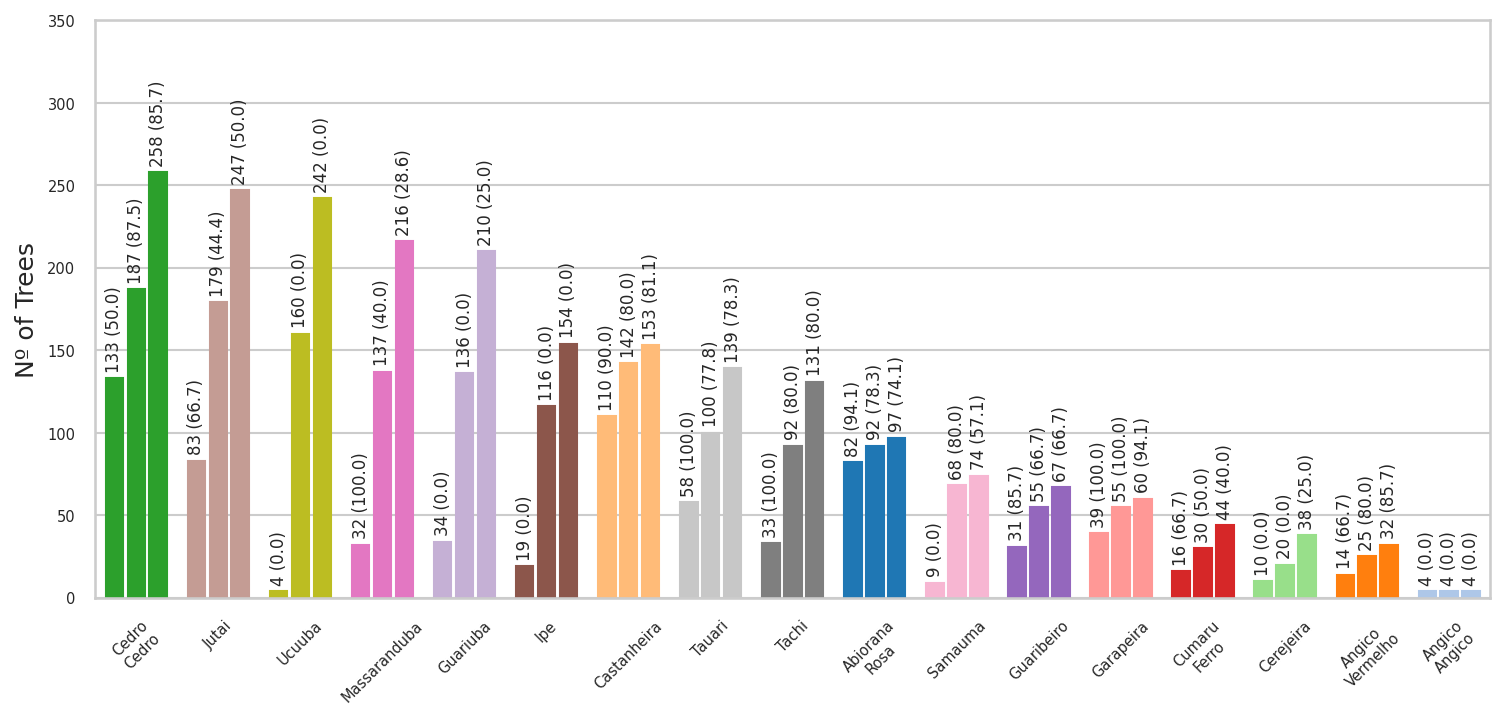

In [59]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

ax = sns.barplot(
    data=f1_score_comp_and_count,
    x="tree_name",
    y="n_trees",
    hue="iter_num",
    order = f1_score_comp_and_count["tree_name"].unique(),
    dodge=True,
)

# Adjust the space between bars
group_spacing = 0.2  # Adjust this value for more/less spacing
for patch in ax.patches:
    current_width = patch.get_width()
    diff = current_width * group_spacing
    new_width = current_width - diff
    patch.set_width(new_width)
    patch.set_x(patch.get_x() + diff/2)
                
# # color each bar group by tree_name
for i, bar in enumerate(ax.patches):
    # print(bar.g)
    tree_name = f1_score_comp_and_count.sort_values(["iter_num", "n_trees_last_iter"], ascending=[True, False])["tree_name"].iloc[i]
    
    bar.set_color(dict_colors["tree_name"][tree_name])
    
    if i >= len(f1_score_comp_and_count["tree_name"])-1 :
        break

ax.tick_params(axis='x', rotation=45)
ax.set_xticklabels([wrap_text(label.get_text(), 9, False) for label in ax.get_xticklabels()])
ax.set_ylim(0, 350)


ax.bar_label(ax.containers[0],
             labels=f1_score_comp_and_count[f1_score_comp_and_count["iter_num"] == 1].apply(
                 lambda x: f"{x['n_trees']} ({x['f1_score_comp']:.1f})", 
                 axis=1),
             label_type='edge', 
             fontsize=8, 
             rotation=90,
             padding=3)

ax.bar_label(ax.containers[1],
                labels=f1_score_comp_and_count[f1_score_comp_and_count["iter_num"] == 8].apply(
                    lambda x: f"{x['n_trees']} ({x['f1_score_comp']:.1f})", 
                    axis=1),
                label_type='edge', 
                fontsize=8,
                rotation=90,
                padding=3)

ax.bar_label(ax.containers[2],
                labels=f1_score_comp_and_count[f1_score_comp_and_count["iter_num"] == 20].apply(
                    lambda x: f"{x['n_trees']} ({x['f1_score_comp']:.1f})", 
                    axis=1),
                label_type='edge', 
                fontsize=8,
                rotation=90, 
                padding=3)
# remove legend
ax.get_legend().remove()

ax.set_xlabel("")
ax.set_ylabel("Nº of Trees")

# # save as pdf
# fig.savefig(
#     join(FIG_PATH,"n_trees_vs_f1_score_by_tree_comp.pdf"),
#     format="pdf",
#     bbox_inches="tight")

fig.show()

In [75]:
df_f1_score_avg = df_f1_comp_by_iter_by_tree.groupby("iter_num", as_index=False)["f1_score"].mean()
count_tree_by_iter = all_labels_stats.groupby("iter_num", as_index=False)["label"].nunique()
count_tree_by_iter.rename(columns={"label": "n_trees"}, inplace=True)

Area Segmented and F1 Score per Iteration


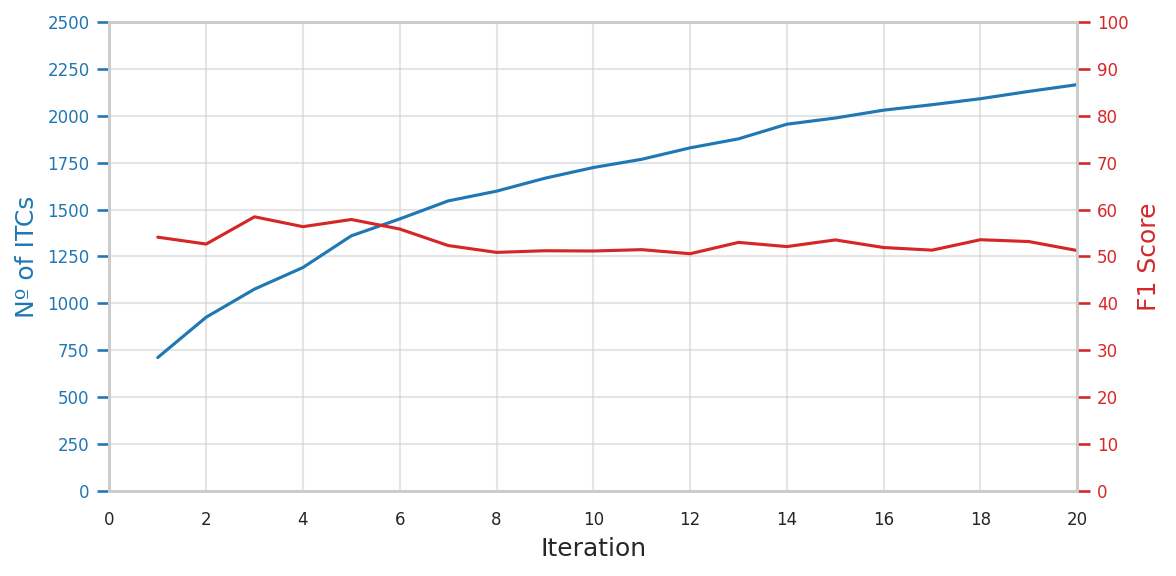

In [76]:
fig, ax1 = plt.subplots(figsize=(8, 4), dpi=150)

# Use azul escuro aqui
color = "tab:blue"
ax1 = sns.lineplot(
    x=count_tree_by_iter["iter_num"].astype(int),
    y=count_tree_by_iter["n_trees"],
    color=color
)
ax1.set_xlabel("Iteration")
ax1.set_xlim(0, 20)
ax1.set_xticks(range(0, 21, 2))


ax1.tick_params(axis="y", labelcolor=color, colors=color)
ax1.set_ylabel("Nº of ITCs", color=color)
ax1.set_yticks(np.linspace(0, 2500, 11))


ax1.grid(alpha=0.5)

# Create a second y-axis to plot the F1-score
ax2 = ax1.twinx()
color = "tab:red"
sns.lineplot(
    x=df_f1_score_avg["iter_num"].astype(int),
    y=df_f1_score_avg["f1_score"],
    color=color,
    ax=ax2
)
ax2.set_ylabel("F1 Score", color=color)
ax2.tick_params(axis="y", labelcolor=color, colors=color)
ax2.set_yticks(np.linspace(0, 1, len(ax1.get_yticks())))
ax2.grid(False)
# format ax2 y labels to percent
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y*100:.0f}"))

ax1.set_yticklabels(ax1.get_yticklabels(), fontdict={"fontsize": 8})
ax1.set_xticklabels(ax1.get_xticklabels(), fontdict={"fontsize": 8})
ax2.set_yticklabels(ax2.get_yticklabels(), fontdict={"fontsize": 8})

print("Area Segmented and F1 Score per Iteration")
fig.tight_layout()

# savefig as pdf
# fig.savefig(join(FIG_PATH,"n_trees_vs_f1_score_comp.pdf"), format="pdf")
plt.show()